In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc("text", usetex=True)
plt.rc("font", **{"family": "DejaVu Sans", "size": 20})
plt.rc("axes", labelsize=16)
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)

from cycler import cycler
from matplotlib import cm
from matplotlib import colors as mc
from matplotlib.colors import LogNorm, PowerNorm
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

%matplotlib inline
# %matplotlib widget

In [2]:
import numpy as np
import h5py

To perform some basic numerical computations, you may want to install the `Pylians3` package. It’s a Python library used in cosmology and numerical simulations, offering tools for handling large datasets, computing statistics, and more.

https://pylians3.readthedocs.io/en/master/index.html

In [3]:
import MAS_library as MASL

We can read the simulation data using the following:

- position: This gives the final positions of the particles in the simulation.
- displacement: This provides the displacement vectors for each particle, indicating how far and in what direction each particle moved from its initial position.

**Note:** Both arrays are sorted in the same order, so you can directly compare corresponding elements between position and displacement.

In [4]:
isim = 0 # simulation id

with h5py.File(f'./data/LSS_{isim}_L100_G64.h5', 'r') as f:
    position     = np.array(f['position'][:], dtype=np.float32)      # Read position dataset into a NumPy array
    displacement = np.array(f['displacement'][:], dtype=np.float32)  # Read displacement dataset
    
# Now `position` and `displacement` are NumPy arrays
print("Position shape:", position.shape)
print("Displacement shape:", displacement.shape)

Position shape: (262144, 3)
Displacement shape: (262144, 3)


We aim to solve a static form of the continuity equation, which describes the conservation of mass during the evolution of a matter distribution.

Let:

- $\mathbf{x}$ be the final positions of particles,
- $\mathbf{q}$ be their initial positions (typically a uniform grid),
- $\rho_{\text{ini}}$ and $\rho_{\text{fin}}$ be the initial and final density fields, respectively.

The continuity equation in its static form is:

$$
\rho_{\mathrm{fin}}(\mathbf{x}) \mathrm{d}^3 \mathbf{x} = \rho_{\mathrm{ini}}(\mathbf{q})  \mathrm{d}^3 \mathbf{q}
$$

This expresses the conservation of mass as particles move from $\mathbf{q}$ to $\mathbf{x}$.

⸻

We define a displacement field $\Psi(\mathbf{x})$ such that the initial position is related to the final position by:

$$
\mathbf{q} = \mathbf{x} + \Psi(\mathbf{x})
$$

This means we are working backwards from the observed final positions to the initial (uniform) state. Substituting into the continuity equation and assuming the initial density is uniform (i.e., $\rho_{\text{ini}} = \bar{\rho}$), we get:

$$
\frac{\rho_{\mathrm{fin}}(\mathbf{x})}{\bar{\rho}} = \left| \frac{\mathrm{d}^3 \mathbf{q}}{\mathrm{d}^3 \mathbf{x}} \right| = \det\left[ \delta_{ij} + \partial_i \Psi_j \right]
$$

This is our target equation; solving for the displacement field $\Psi(\mathbf{x})$ given the final density field $\rho_{\mathrm{fin}}(\mathbf{x})$:

$$
\frac{\rho_{\mathrm{fin}}(\mathbf{x})}{\bar{\rho}} = \det\left[ 1 + \partial_i \Psi_j \right]
$$

⸻

Simulation Data Notes

From the simulation files:
	•	position → $\mathbf{x}$ (final positions of particles)
	•	displacement → $\Psi(\mathbf{x})$ (displacement vectors at those positions)

You can verify the setup by checking:

$$
\mathbf{x} + \Psi(\mathbf{x}) = \mathbf{q}
$$

This should reconstruct the initial uniform grid used in the simulation.

**Note:** These simulations use periodic boundary conditions — make sure to account for this in any spatial calculations.

In [5]:
BoxSize  = 100.0         #Mpc/h ; size of box
grid     = 64            #the 3D field will have grid x grid x grid voxels
cellsize = BoxSize/grid

(position + displacement)%BoxSize / cellsize

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.99999994],
       [ 0.        ,  0.        ,  2.        ],
       ...,
       [63.        , 63.        , 61.        ],
       [63.        , 63.        , 62.        ],
       [63.        , 63.        , 63.        ]], dtype=float32)

In [6]:
# We can get the density like this:
# density field parameters
MAS     = 'CIC'  #mass-assigment scheme
verbose = False   #print information on progress
threads = 4

rho = np.zeros((grid, grid, grid), dtype=np.float32)
MASL.MA(position, rho, BoxSize, MAS, verbose=verbose)
rho_rhobar = rho / np.mean(rho, dtype=np.float64)

In [7]:
rho_rhobar.shape

(64, 64, 64)

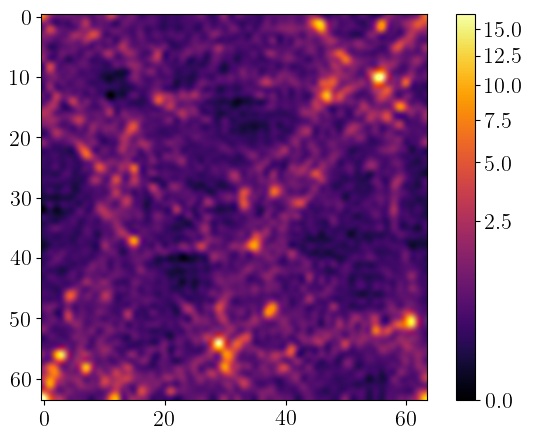

In [10]:
# To just take a look at the density field!

plt.imshow(rho_rhobar[:32].mean(axis=0), cmap='inferno', norm=PowerNorm(0.4), interpolation='lanczos', interpolation_stage='rgba')
plt.colorbar()
plt.tight_layout()

I believe we probably need to get the displacement field on a grid, too! 

Since the final particle positions $\mathbf{x}$ are not uniformly distributed (due to gravitational clustering), directly computing derivatives like $\partial_i \Psi_j(\mathbf{x})$ on a nonuniform set can be numerically unstable, particularly in overdense and underdense regions.

To avoid this, we can reformulate the problem in terms of the initial positions $\mathbf{q}$, which lie on a uniform grid by construction.

Instead of expressing displacement as $\mathbf{q} = \mathbf{x} + \Psi(\mathbf{x})$, we use:

$$
\mathbf{x} = \mathbf{q} + \tilde{\Psi}(\mathbf{q})
$$

Here, $\tilde{\Psi} = -\Psi$ is the displacement field defined on the uniform grid.

Rewriting the continuity equation in terms of $\mathbf{q}$:

$$
\frac{1}{\frac{\rho_{\mathrm{fin}}(\mathbf{x})}{\bar{\rho}}} = \left|\frac{\mathrm{d}^3 \mathbf{x}}{\mathrm{d}^3 \mathbf{q}}\right| = \det\left[ \delta_{ij} + \partial_{q_i} \tilde{\Psi}_j(\mathbf{q}) \right]
$$

I think this form should be more stable and practical for numerical implementations, especially when working with grid-based methods; but just try and see what we get!
